<a href="https://www.kaggle.com/code/emrekaany/try-usd-fx-rates-and-financials-eda?scriptVersionId=236110575" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# --- 1. Import Necessary Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno # For visualizing missing data
from statsmodels.tsa.seasonal import seasonal_decompose # For time series decomposition
from statsmodels.tsa.stattools import adfuller # Stationarity test (ADF)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Autocorrelation plots
import matplotlib.dates as mdates # For date formatting on plots
# For debugging:
import traceback

# --- 2. Load Datasets  ---
try:
    base_path = "/kaggle/input/usd-try-conv-rates-and-related-data/"
    
    usd_try = pd.read_csv(base_path + "USD_TRY_CONVERSION_RATE.csv", parse_dates=['Date'], dayfirst=True)
    repo_rate = pd.read_csv(base_path + "Repo_1Day_Weighted_Average_Rate.csv", parse_dates=['Date'], dayfirst=True)
    net_funding = pd.read_csv(base_path + "TCMB_Net_Funding.csv", parse_dates=['Date'])
    fx_volume = pd.read_csv(base_path + "FX_TRANSACTION_VOLUME.csv", parse_dates=['Date'])
    fx_swap = pd.read_csv(base_path + "FX_Swap_Deposit_Amount.csv", parse_dates=['Date'], dayfirst=True)



    tl_interest = pd.read_csv(base_path + "TL_INTEREST_RATE.csv", parse_dates=['Date'], dayfirst=True)
    usd_interest = pd.read_csv(base_path + "USD_INTEREST_RATE.csv", parse_dates=['Date'], dayfirst=True)
    inflation_expectation = pd.read_csv(base_path + "Inflation_Expectation_12M.csv", parse_dates=['Date'], dayfirst=True)
    cpi = pd.read_csv(base_path + "CPI_General_Index.csv", parse_dates=['Date'], dayfirst=True) 
    print("All datasets loaded successfully.")

except FileNotFoundError as e:
    print(f"Error loading file: {e}. Please ensure file names in '/kaggle/input/usd-try-conv-rates-and-related-data/' are correct.")
    raise e
except Exception as e:
    print(f"Unexpected error loading data: {e}")
    # Print the full traceback for the error
    traceback.print_exc()
    raise e


All datasets loaded successfully.


In [2]:

# --- 3. Initial Inspection & Preprocessing ---

data_frames_list = [
    usd_try, repo_rate, net_funding, fx_volume, fx_swap,
    tl_interest, usd_interest, inflation_expectation, cpi
]
df_names = [
    'usd_try', 'repo_rate', 'net_funding', 'fx_volume', 'fx_swap',
    'tl_interest', 'usd_interest', 'inflation_expectation', 'cpi'
]

processed_dfs = {} # To store processed dfs
for name, df in zip(df_names, data_frames_list):
    if df is None:
        print(f"--- {name} (skipped, not loaded) ---")
        continue

    if df.empty:
        print(f"WARNING: {name} DataFrame is empty!")
        processed_dfs[name] = pd.DataFrame() # Add empty df
        continue

    temp_df = df.copy() # Take a copy to avoid modifying the original

    # Process 'Date' column
    if 'Date' in temp_df.columns:
        if not pd.api.types.is_datetime64_any_dtype(temp_df['Date']):
            try:
                temp_df['Date'] = pd.to_datetime(temp_df['Date'])
            except Exception as date_err:
                print(f"WARNING: 'Date' column for {name} could not be converted to datetime: {date_err}. Skipping this DataFrame.")
                processed_dfs[name] = pd.DataFrame() # Mark the failed one as empty
                continue
        temp_df.set_index('Date', inplace=True)
    elif temp_df.index.name == 'Date' and pd.api.types.is_datetime64_any_dtype(temp_df.index):
         # If Date is already the index and is datetime, no problem
         pass
    else:
        print(f"WARNING: Valid 'Date' column or datetime index not found in {name} DataFrame! Skipping this DataFrame.")
        processed_dfs[name] = pd.DataFrame() # Mark the failed one as empty
        continue

    # Remove helper columns
    if 'Year_Week' in temp_df.columns:
        temp_df.drop(columns=['Year_Week'], inplace=True)

    # Numeric conversion
    for col in temp_df.columns:
        if col != 'Date': # Date is already the index
            temp_df[col] = pd.to_numeric(temp_df[col], errors='coerce')

    processed_dfs[name] = temp_df # Store the processed df


In [3]:

# --- 4. Merging Strategy: Outer Merge + Forward Fill ---
df_merged = None
base_df_name = None

# Find the first valid, non-empty DataFrame
for name in df_names:
    if name in processed_dfs and not processed_dfs[name].empty and processed_dfs[name].index.name == 'Date':
        df_merged = processed_dfs[name].copy()
        base_df_name = name
        print(f"Base DataFrame for merging: {base_df_name}")
        break

if df_merged is None:
    print("ERROR: Suitable base DataFrame for merging not found.")
    raise ValueError("No base DataFrame for merging.")

# Merge the remaining DataFrames
for name in df_names:
    if name == base_df_name: # Skip the base df
        continue
    if name in processed_dfs and not processed_dfs[name].empty and processed_dfs[name].index.name == 'Date':
        df_to_merge = processed_dfs[name]
        # Add suffix to prevent column name conflicts
        # If a column with the same name exists, adds _dfname to the second one
        df_merged = df_merged.merge(df_to_merge, left_index=True, right_index=True, how='outer', suffixes=('', f'_{name}'))
    elif name in processed_dfs and processed_dfs[name].empty:
         print(f"Warning: '{name}' DataFrame could not be merged because it is empty.")
    elif name in processed_dfs:
         print(f"Warning: '{name}' DataFrame could not be merged because it has no valid Date index.")

# Sort by date
df_merged.sort_index(inplace=True)



Base DataFrame for merging: usd_try



--- Missing Data Before Forward Fill ---
Conversion_Rate                    1143
Repo_1Day_Weighted_Average_Rate    3558
Net_Funding_Million_TRY            1143
Transaction_Volume                 1856
FX_Swap_Deposit_Amount             3108
TRY_Interest_Rate_6Month           3134
USD_Interest_Rate_6Month           3134
Inflation_Expectation_12M          3535
CPI_Index                          3535
dtype: int64


<Figure size 1500x800 with 0 Axes>

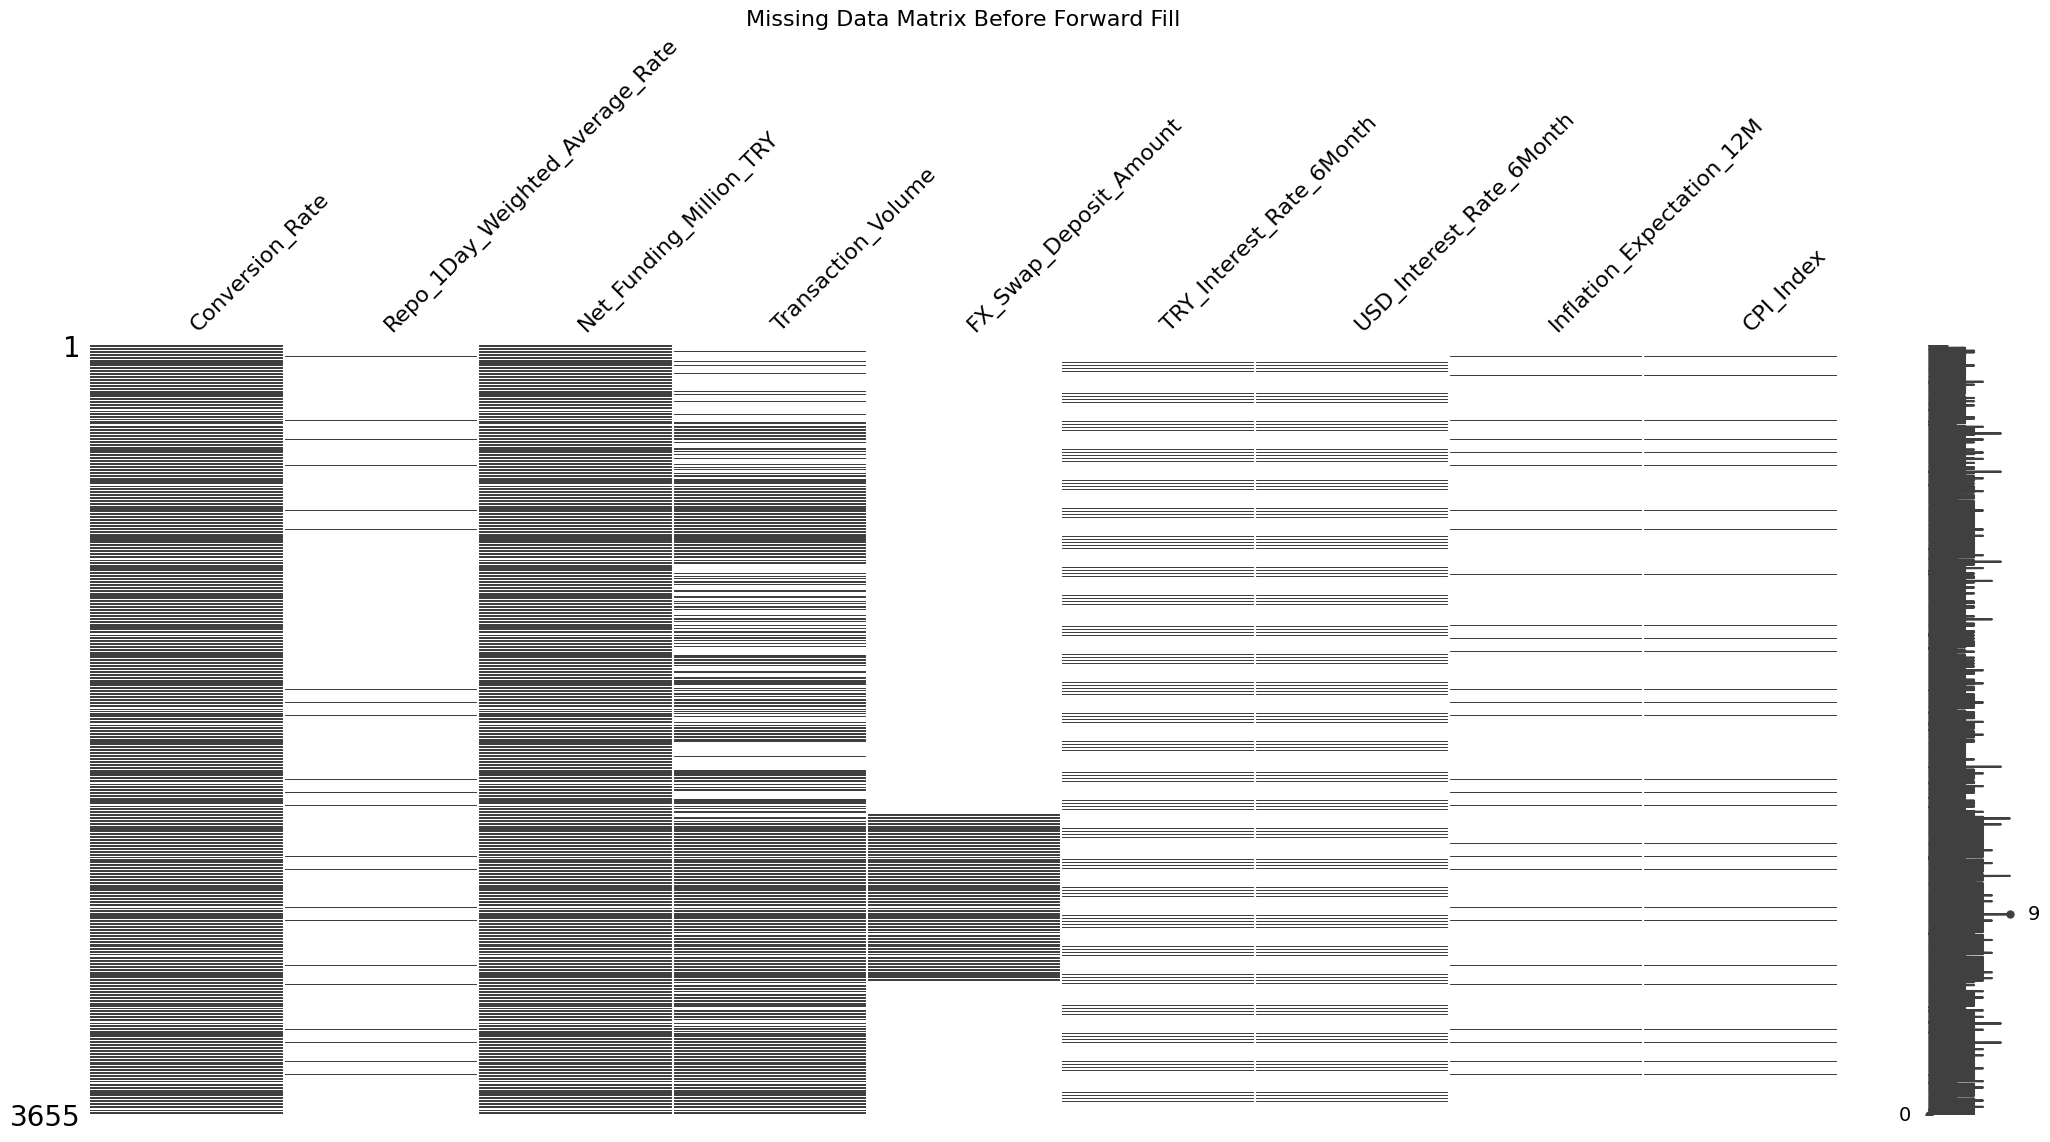


--- Missing Data After Forward Fill ---
Conversion_Rate                      1
Repo_1Day_Weighted_Average_Rate      0
Net_Funding_Million_TRY              1
Transaction_Volume                   1
FX_Swap_Deposit_Amount             636
TRY_Interest_Rate_6Month             1
USD_Interest_Rate_6Month             1
Inflation_Expectation_12M            0
CPI_Index                            0
dtype: int64
1 rows with NaN 'Conversion_Rate' removed.
       Conversion_Rate  Repo_1Day_Weighted_Average_Rate  \
count      3654.000000                      3654.000000   
mean         11.941139                        19.797044   
std          10.684432                        13.547282   
min           2.566900                         7.260000   
25%           3.760400                        10.650000   
50%           6.782200                        15.090000   
75%          18.568700                        20.500000   
max          38.131400                        53.000000   

       Net_Funding_M

In [4]:

# --- 5. Handle Missing Data ---
print("\n--- Missing Data Before Forward Fill ---")
print(df_merged.isnull().sum())

plt.figure(figsize=(15, 8))
msno.matrix(df_merged.sort_index(ascending=False))
plt.title('Missing Data Matrix Before Forward Fill', fontsize=16)
plt.show() # This show() command should be complete

df_merged_filled = df_merged.ffill()

print("\n--- Missing Data After Forward Fill ---")
print(df_merged_filled.isnull().sum())

if 'Conversion_Rate' in df_merged_filled.columns:
    initial_rows = len(df_merged_filled)
    df_merged_filled.dropna(subset=['Conversion_Rate'], inplace=True)
    print(f"{initial_rows - len(df_merged_filled)} rows with NaN 'Conversion_Rate' removed.")
else:
    print("WARNING: 'Conversion_Rate' column not found, could not clean NaN rows.")


try:
    # Describe only numeric columns
    print(df_merged_filled.describe(include=[np.number]))
except Exception as desc_err:
    print(f"Describe error: {desc_err}.")
    # Show head for a general overview if describe fails



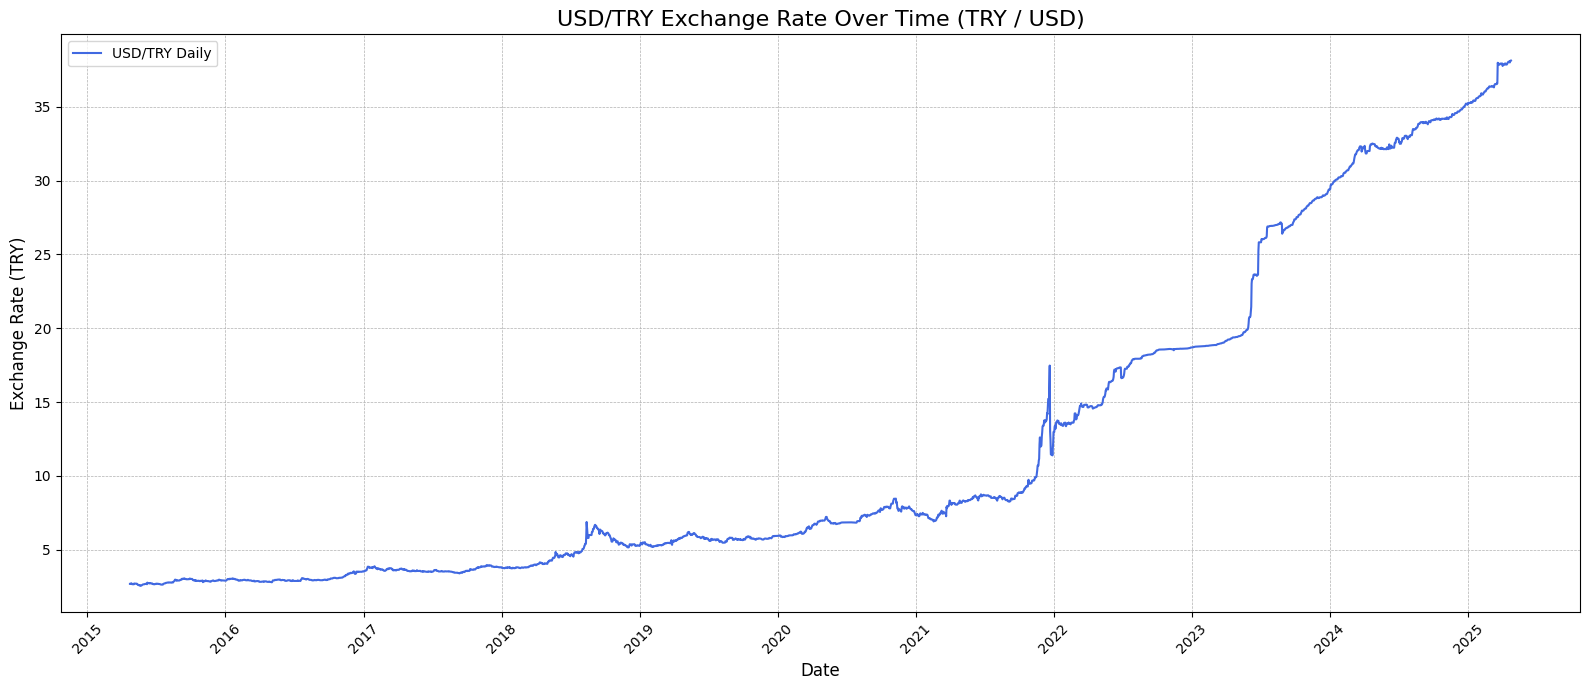

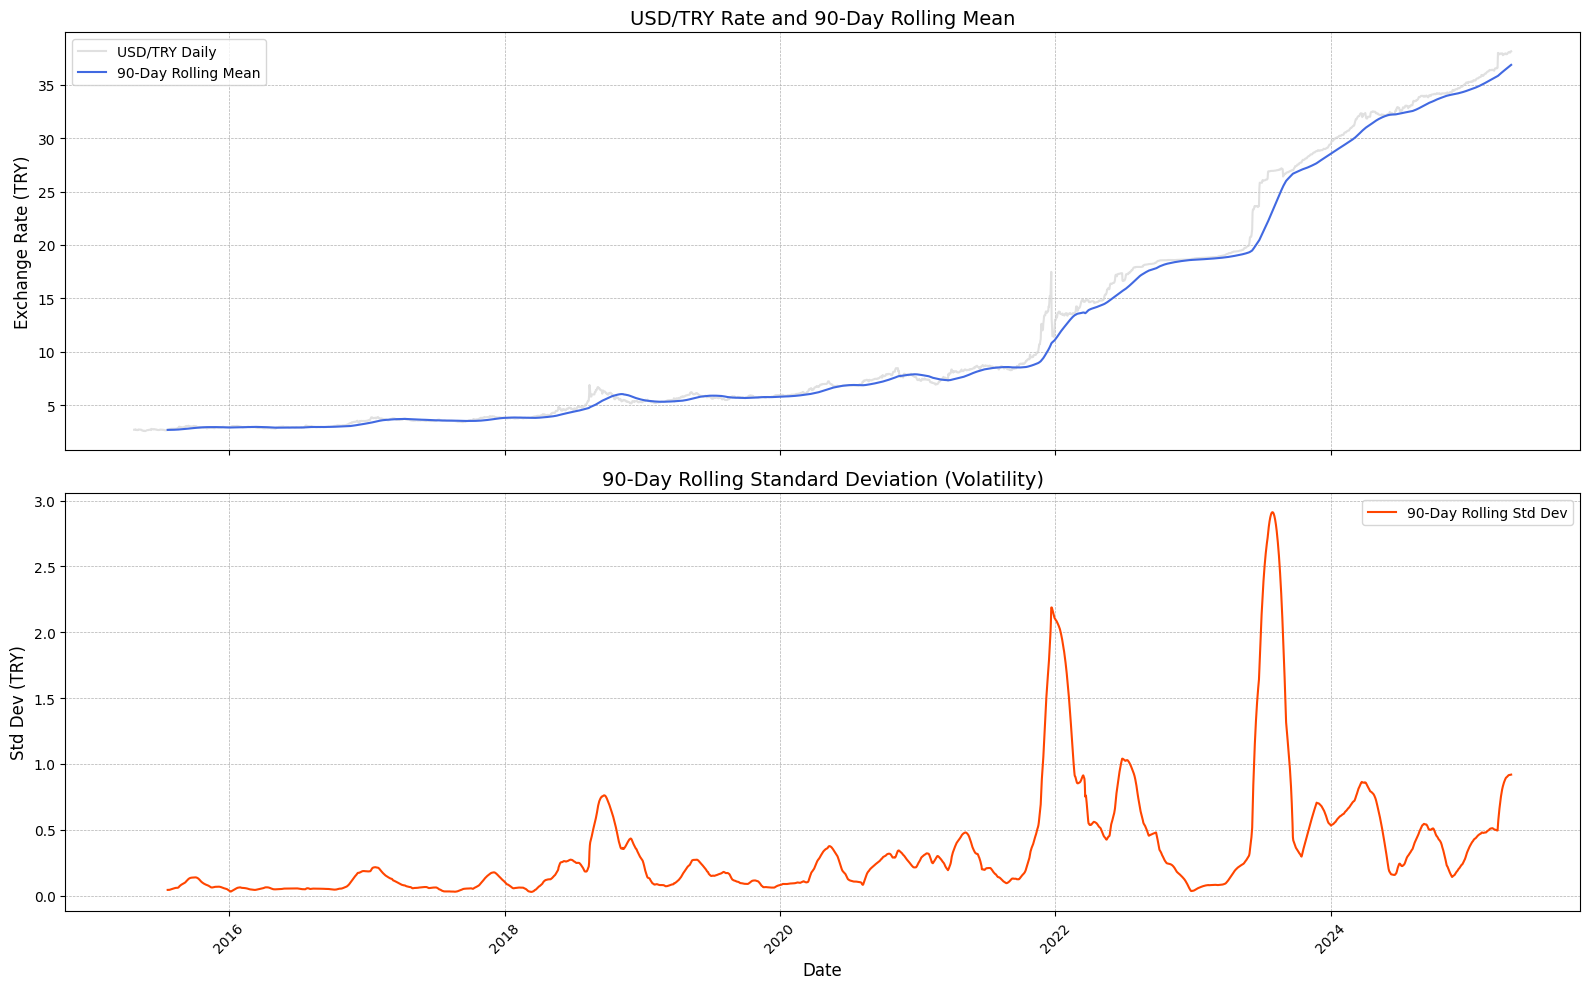

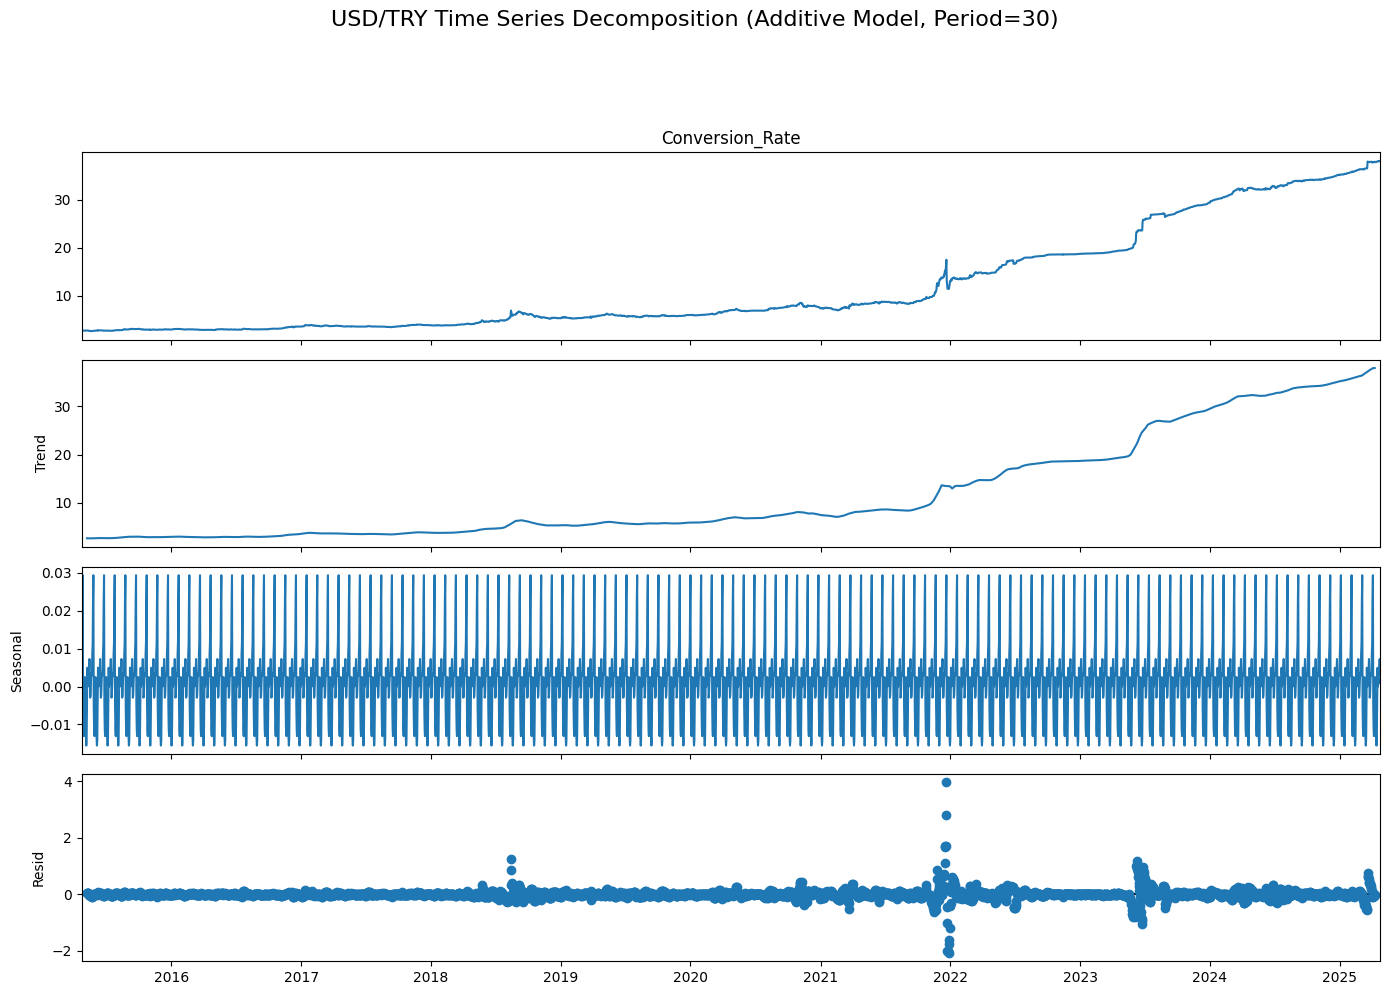

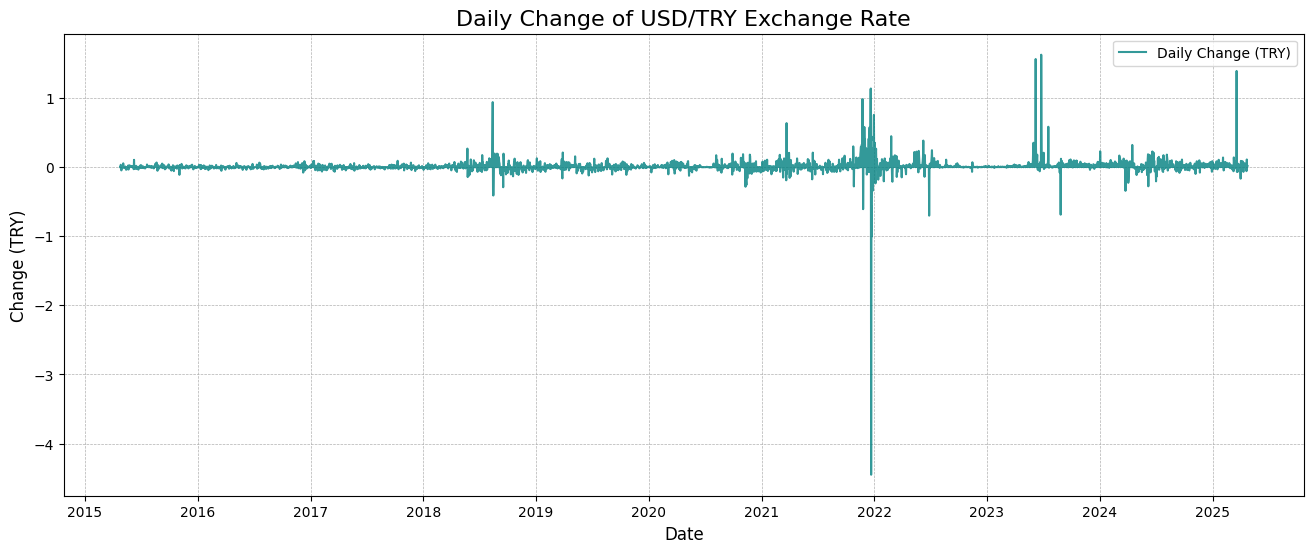


--- Stationarity Test Results (ADF) for USD/TRY Rate ---
Test Statistic                    2.704940
p-value                           0.999087
# Lags Used                      28.000000
Number of Observations Used    3625.000000
Critical Value (1%)              -3.432155
Critical Value (5%)              -2.862338
Critical Value (10%)             -2.567195
dtype: float64
Result: USD/TRY Rate does not appear stationary (p > 0.05). Failed to reject null hypothesis.

--- Stationarity Test Results (ADF) for USD/TRY Daily Change ---
Test Statistic                -8.946402e+00
p-value                        8.964157e-15
# Lags Used                    2.700000e+01
Number of Observations Used    3.625000e+03
Critical Value (1%)           -3.432155e+00
Critical Value (5%)           -2.862338e+00
Critical Value (10%)          -2.567195e+00
dtype: float64
Result: USD/TRY Daily Change appears stationary (p <= 0.05). Null hypothesis rejected.


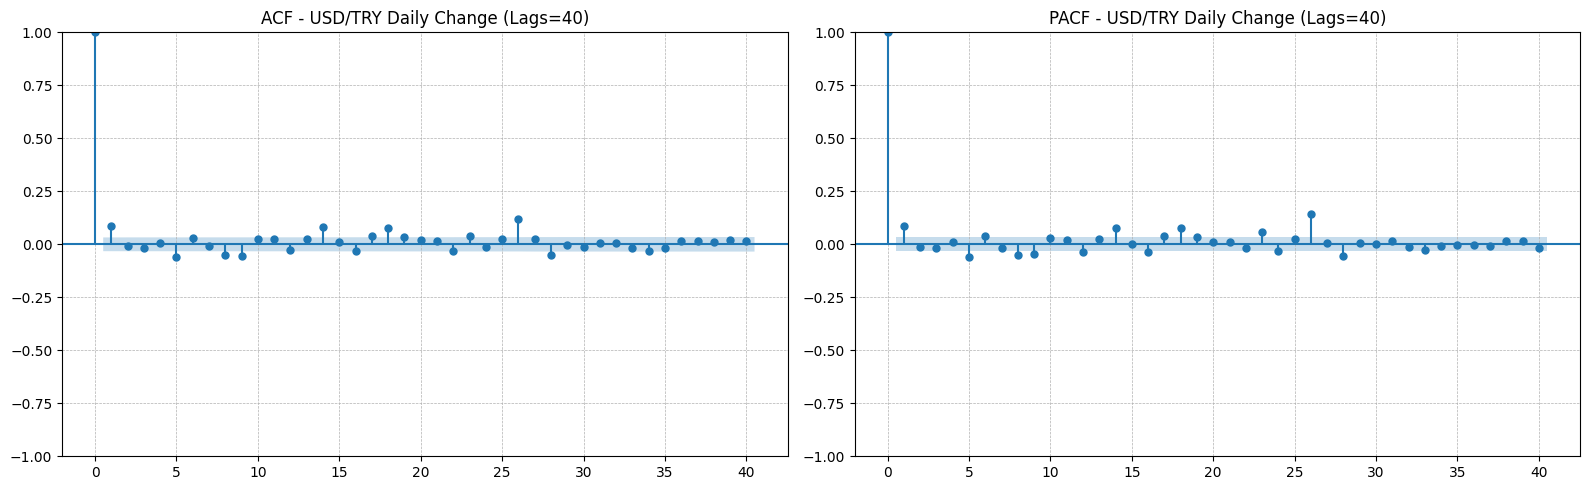

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


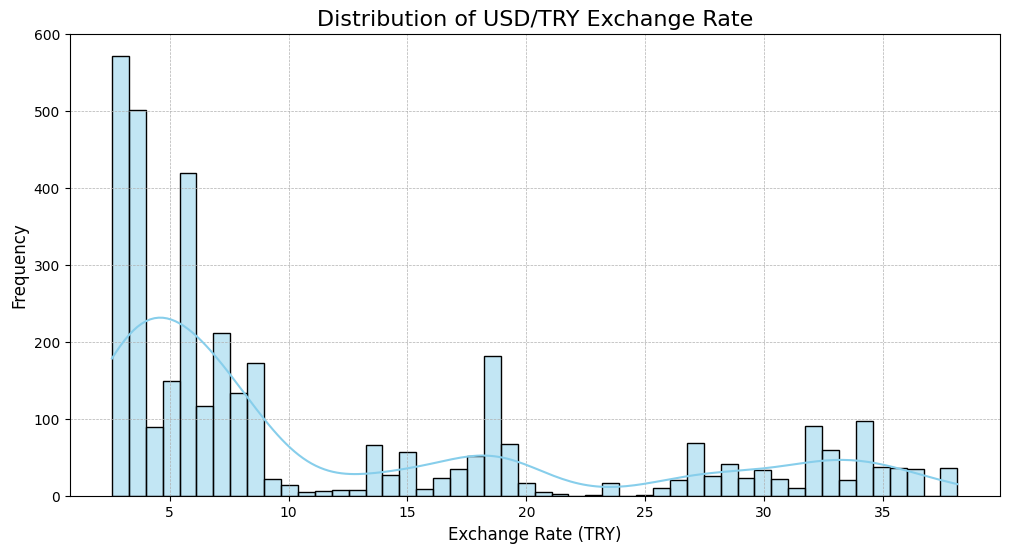

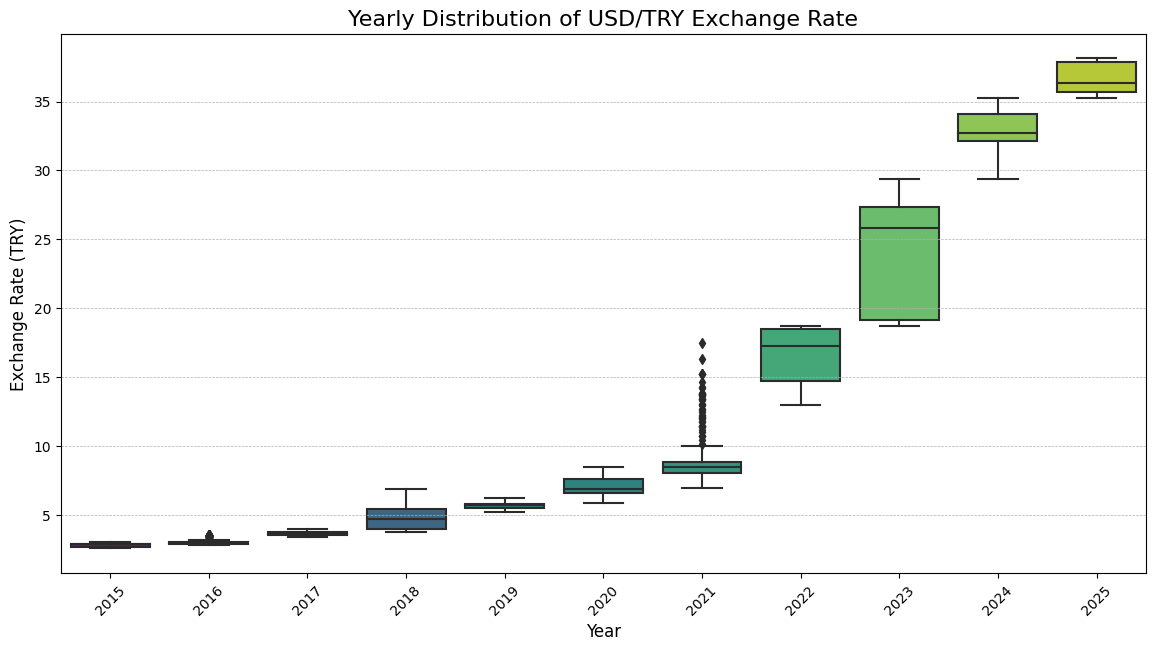

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


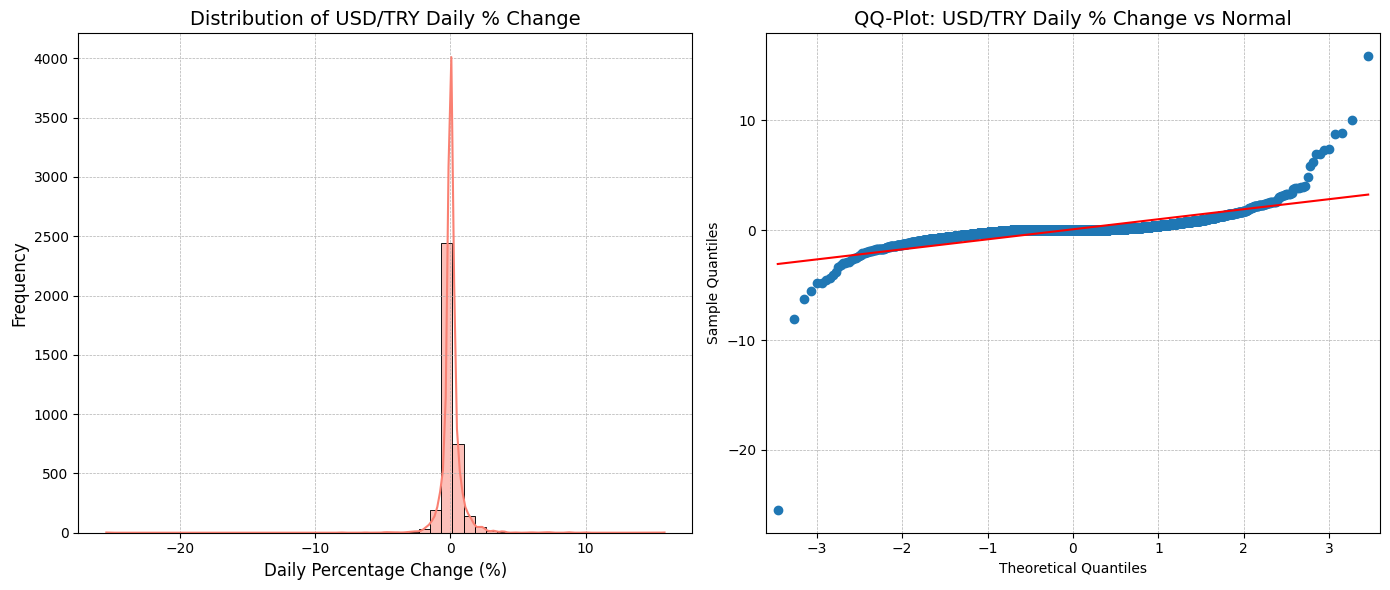

In [5]:

# --- 6. Comprehensive Exploratory Data Analysis (EDA) ---

# -- 6.a Univariate Time Series Analysis (USD/TRY) --
if 'Conversion_Rate' in df_merged_filled.columns:
    # Plotting USD/TRY Conversion Rate over time
    fig, ax = plt.subplots(figsize=(16, 7))
    ax.plot(df_merged_filled.index, df_merged_filled['Conversion_Rate'], label='USD/TRY Daily', color='royalblue')
    ax.set_title('USD/TRY Exchange Rate Over Time (TRY / USD)', fontsize=16)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Exchange Rate (TRY)', fontsize=12)
    ax.legend()
    ax.xaxis.set_major_locator(mdates.YearLocator()) # Major ticks every year
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y')) # Format as year
    plt.xticks(rotation=45)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show() # Completed command

    # Rolling Statistics for USD/TRY
    rolling_window = 90 # Approx 3 months
    df_merged_filled['Rolling_Mean_USDTRY'] = df_merged_filled['Conversion_Rate'].rolling(window=rolling_window).mean()
    df_merged_filled['Rolling_Std_USDTRY'] = df_merged_filled['Conversion_Rate'].rolling(window=rolling_window).std()

    fig, ax = plt.subplots(2, 1, figsize=(16, 10), sharex=True)
    ax[0].plot(df_merged_filled.index, df_merged_filled['Conversion_Rate'], label='USD/TRY Daily', color='lightgray', alpha=0.7)
    ax[0].plot(df_merged_filled.index, df_merged_filled['Rolling_Mean_USDTRY'], label=f'{rolling_window}-Day Rolling Mean', color='royalblue')
    ax[0].set_title(f'USD/TRY Rate and {rolling_window}-Day Rolling Mean', fontsize=14)
    ax[0].set_ylabel('Exchange Rate (TRY)', fontsize=12)
    ax[0].legend()
    ax[0].grid(True, which='both', linestyle='--', linewidth=0.5)

    ax[1].plot(df_merged_filled.index, df_merged_filled['Rolling_Std_USDTRY'], label=f'{rolling_window}-Day Rolling Std Dev', color='orangered')
    ax[1].set_title(f'{rolling_window}-Day Rolling Standard Deviation (Volatility)', fontsize=14)
    ax[1].set_xlabel('Date', fontsize=12)
    ax[1].set_ylabel('Std Dev (TRY)', fontsize=12)
    ax[1].legend()
    ax[1].grid(True, which='both', linestyle='--', linewidth=0.5)

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show() # Completed command

    # Time Series Decomposition
    try:
        # Choosing an appropriate period is important. 30 days or 252 business days (yearly) can be tried.
        # NaNs at the beginning of the data can cause issues, so dropna() is important.
        data_to_decompose = df_merged_filled['Conversion_Rate'].dropna()
        if len(data_to_decompose) > 2 * 30: # Must have at least 2 periods of data
            decomposition = seasonal_decompose(data_to_decompose, model='additive', period=30) # Approx monthly period
            fig = decomposition.plot()
            fig.set_size_inches(14, 10)
            fig.suptitle('USD/TRY Time Series Decomposition (Additive Model, Period=30)', y=1.02, fontsize=16)
            plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
            plt.show() # Completed command
        else:
            print("Not enough data for time series decomposition (at least 2x period required).")
    except ValueError as decomp_err:
        print(f"Time series decomposition error: {decomp_err}. Period value might be longer than the data.")
    except Exception as e:
        print(f"Unexpected error in time series decomposition: {e}")


    # USD/TRY Daily Changes
    df_merged_filled['USDTRY_Daily_Change'] = df_merged_filled['Conversion_Rate'].diff()
    df_merged_filled['USDTRY_Daily_Pct_Change'] = df_merged_filled['Conversion_Rate'].pct_change() * 100 # Percentage change

    plt.figure(figsize=(16, 6))
    plt.plot(df_merged_filled.index, df_merged_filled['USDTRY_Daily_Change'], label='Daily Change (TRY)', color='teal', alpha=0.8)
    plt.title('Daily Change of USD/TRY Exchange Rate', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Change (TRY)', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.show() # Completed command

    # Stationarity Test (ADF - Augmented Dickey-Fuller)
    def check_stationarity(series, series_name="Series"):
        # Function as before...
        series_cleaned = series.dropna()
        if series_cleaned.empty or len(series_cleaned) < 10: # Test is meaningless with too little data
            print(f"{series_name} does not contain enough data for stationarity test.")
            return None # Indicate test couldn't be performed

        print(f'\n--- Stationarity Test Results (ADF) for {series_name} ---')
        try:
            adf_test = adfuller(series_cleaned, autolag='AIC')
            adf_output = pd.Series(adf_test[0:4], index=['Test Statistic','p-value','# Lags Used','Number of Observations Used'])
            for key,value in adf_test[4].items():
                adf_output[f'Critical Value ({key})'] = value
            print(adf_output)
            if adf_test[1] <= 0.05:
                print(f"Result: {series_name} appears stationary (p <= 0.05). Null hypothesis rejected.")
                return True # Stationary
            else:
                print(f"Result: {series_name} does not appear stationary (p > 0.05). Failed to reject null hypothesis.")
                return False # Not stationary
        except Exception as adf_err:
            print(f"Error during ADF test ({series_name}): {adf_err}")
            return None

    is_stationary_level = check_stationarity(df_merged_filled.get('Conversion_Rate'), "USD/TRY Rate")
    is_stationary_diff = check_stationarity(df_merged_filled.get('USDTRY_Daily_Change'), "USD/TRY Daily Change")


    # Autocorrelation and Partial Autocorrelation (ACF/PACF) Plots
    fig, ax = plt.subplots(1, 2, figsize=(16, 5))
    data_for_acf_pacf = df_merged_filled['USDTRY_Daily_Change'].dropna()
    # Number of lags should be less than the number of observations
    n_obs = len(data_for_acf_pacf)
    n_lags = min(40, n_obs // 2 - 1) # Determine a safe number of lags

    if not data_for_acf_pacf.empty and n_lags > 0: # Plot if there's enough data and lags
        try:
            plot_acf(data_for_acf_pacf, ax=ax[0], lags=n_lags, title=f'ACF - USD/TRY Daily Change (Lags={n_lags})')
            plot_pacf(data_for_acf_pacf, ax=ax[1], lags=n_lags, title=f'PACF - USD/TRY Daily Change (Lags={n_lags})')
            ax[0].grid(True, linestyle='--', linewidth=0.5)
            ax[1].grid(True, linestyle='--', linewidth=0.5)
            plt.tight_layout()
            plt.show() # Completed command
        except Exception as acf_err:
             print(f"ACF/PACF plotting error: {acf_err}")
             # Sometimes plotting separately works if this fails
             try:
                 fig_acf, ax_acf = plt.subplots(figsize=(8, 5))
                 plot_acf(data_for_acf_pacf, ax=ax_acf, lags=n_lags, title=f'ACF - USD/TRY Daily Change (Lags={n_lags})')
                 ax_acf.grid(True, linestyle='--', linewidth=0.5)
                 plt.show()

                 fig_pacf, ax_pacf = plt.subplots(figsize=(8, 5))
                 plot_pacf(data_for_acf_pacf, ax=ax_pacf, lags=n_lags, title=f'PACF - USD/TRY Daily Change (Lags={n_lags})')
                 ax_pacf.grid(True, linestyle='--', linewidth=0.5)
                 plt.show()
             except Exception as e2:
                 print(f"Error occurred during separate ACF/PACF plotting as well: {e2}")

    else:
        print(f"Not enough data or lags for ACF/PACF plotting (Data: {n_obs}, Lags: {n_lags}).")

else:
    print("WARNING: 'Conversion_Rate' column not available for analysis.")


# -- 6.b Distribution Analysis --
if 'Conversion_Rate' in df_merged_filled.columns:
    plt.figure(figsize=(12, 6))
    sns.histplot(df_merged_filled['Conversion_Rate'].dropna(), kde=True, bins=50, color='skyblue') # Added dropna
    plt.title('Distribution of USD/TRY Exchange Rate', fontsize=16)
    plt.xlabel('Exchange Rate (TRY)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.show() # Completed command

    if 'Year' not in df_merged_filled.columns: # Create Year column if it doesn't exist
         df_merged_filled['Year'] = df_merged_filled.index.year

    plt.figure(figsize=(14, 7))
    # Use non-NaN data for boxplot
    plot_data = df_merged_filled[['Year', 'Conversion_Rate']].dropna()
    if not plot_data.empty:
        sns.boxplot(x='Year', y='Conversion_Rate', data=plot_data, palette='viridis')
        plt.title('Yearly Distribution of USD/TRY Exchange Rate', fontsize=16)
        plt.xlabel('Year', fontsize=12)
        plt.ylabel('Exchange Rate (TRY)', fontsize=12)
        plt.xticks(rotation=45)
        plt.grid(True, axis='y', linestyle='--', linewidth=0.5)
        plt.show() # Completed command
    else:
        print("No data for yearly Boxplot.")

if 'USDTRY_Daily_Pct_Change' in df_merged_filled.columns:
    # Distribution of USD/TRY Daily Percentage Change and QQ-Plot
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    data_pct_change = df_merged_filled['USDTRY_Daily_Pct_Change'].dropna()
    if not data_pct_change.empty:
        sns.histplot(data_pct_change, kde=True, bins=50, color='salmon')
        plt.title('Distribution of USD/TRY Daily % Change', fontsize=14)
        plt.xlabel('Daily Percentage Change (%)', fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        plt.grid(True, linestyle='--', linewidth=0.5)

        # QQ-Plot (against Normal distribution)
        from statsmodels.graphics.gofplots import qqplot
        plt.subplot(1, 2, 2)
        try:
            qqplot(data_pct_change, line='s', ax=plt.gca()) # 's' standardized line
            plt.title('QQ-Plot: USD/TRY Daily % Change vs Normal', fontsize=14)
            plt.grid(True, linestyle='--', linewidth=0.5)
            plt.tight_layout() # Adjust spacing between subplots
            plt.show() # Completed command
        except Exception as qq_err:
             print(f"QQ-Plot drawing error: {qq_err}")
             plt.close() # Close the figure if error occurs
    else:
         print("No data for daily % change distribution and QQ-Plot.")
else:
     print("'USDTRY_Daily_Pct_Change' column missing for daily % change analysis.")



In [6]:

# -- 6.c Multivariate Analysis --

# Interest Rate Differential Calculation
tl_col = 'TRY_Interest_Rate_6Month' # Column name from tl_interest
usd_col = 'USD_Interest_Rate_6Month' # Column name from usd_interest
if tl_col in df_merged_filled.columns and usd_col in df_merged_filled.columns:
    df_merged_filled['Interest_Rate_Differential'] = df_merged_filled[tl_col] - df_merged_filled[usd_col]
    print("Interest rate differential calculated.")
else:
    print(f"WARNING: Required columns ({tl_col}, {usd_col}) not found for calculating interest rate differential.")
    if 'Interest_Rate_Differential' not in df_merged_filled.columns:
        df_merged_filled['Interest_Rate_Differential'] = np.nan # Create column as NaN if it doesn't exist


Interest rate differential calculated.


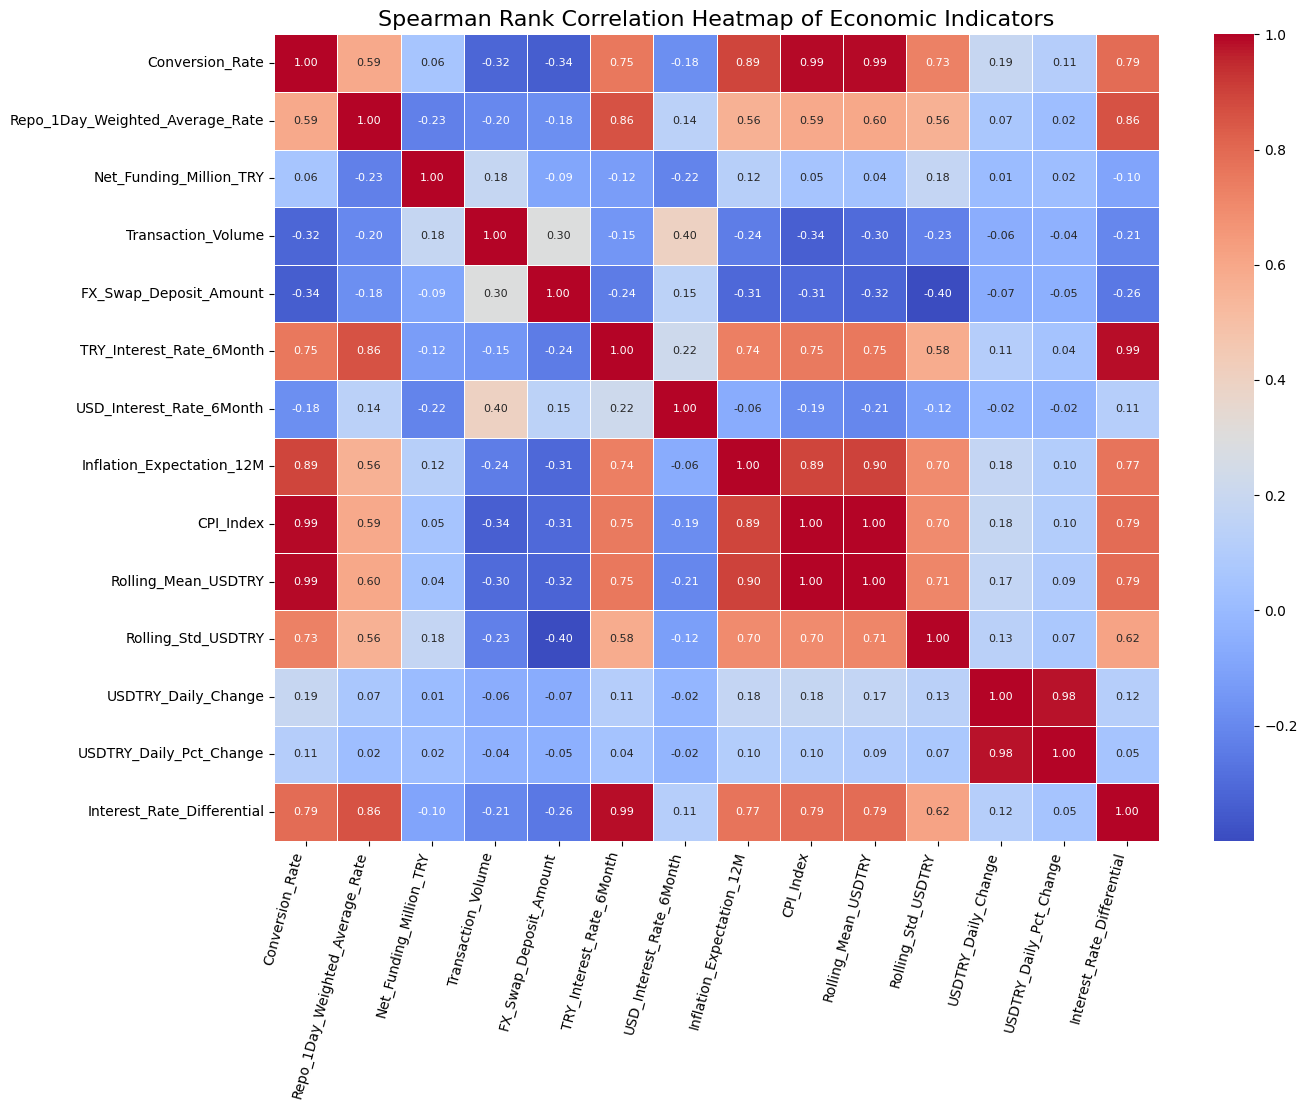

In [7]:

# Correlation Heatmap (Spearman)
numeric_cols_df = df_merged_filled.select_dtypes(include=np.number)
if 'Year' in numeric_cols_df.columns:
    numeric_cols_df = numeric_cols_df.drop(columns=['Year'], errors='ignore')

if not numeric_cols_df.empty:
    # Remove columns that are all NaN or have constant values
    numeric_cols_df = numeric_cols_df.dropna(axis=1, how='all') # Drop entirely NaN columns
    numeric_cols_df = numeric_cols_df.loc[:, numeric_cols_df.apply(pd.Series.nunique) > 1] # Drop constant value columns

    if not numeric_cols_df.empty:
        # Dynamic figure size based on number of columns
        plt.figure(figsize=(max(12, len(numeric_cols_df.columns)), max(10, len(numeric_cols_df.columns)*0.8)))
        corr_matrix = numeric_cols_df.corr(method='spearman')
        sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5, annot_kws={"size": 8}) # Reduced annot size
        plt.title('Spearman Rank Correlation Heatmap of Economic Indicators', fontsize=16)
        plt.xticks(rotation=75, ha='right') # Steeper angle for readability
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show() # Completed command
    else:
         print("No (non-NaN, varying) numeric columns left to calculate correlation.")
else:
     print("No numeric columns found for correlation heatmap.")



Taking 1500 sample for pair plot from 3654 rows.


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

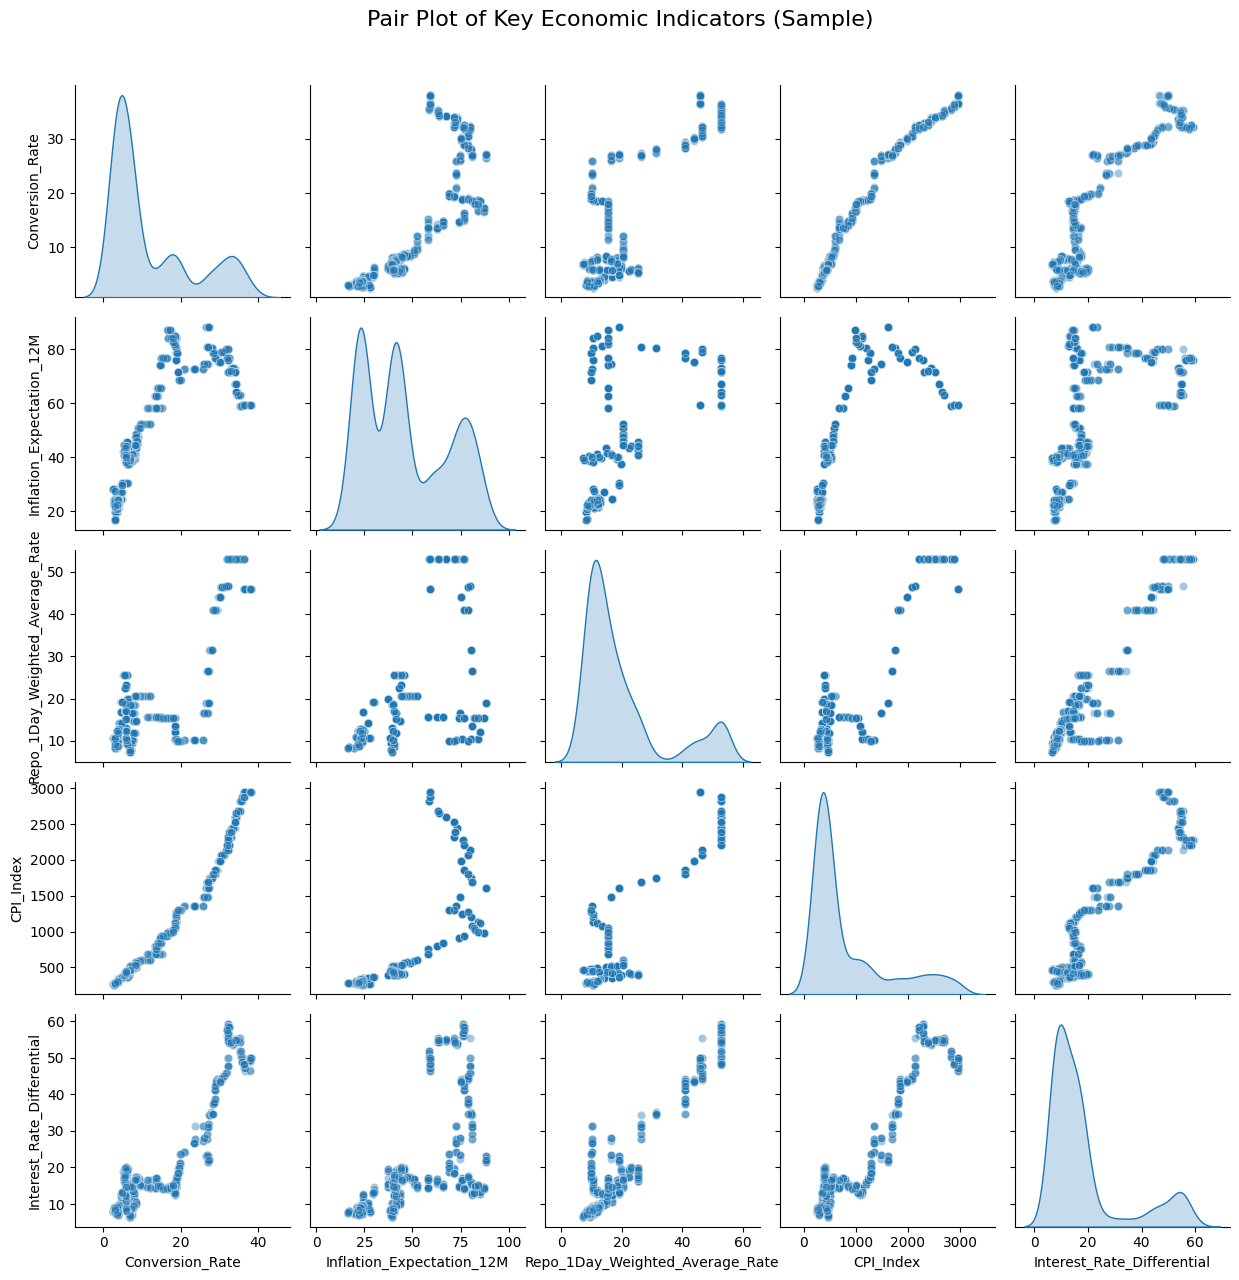

In [8]:

# Pair Plot for Selected Variables
key_vars_list = ['Conversion_Rate',
                 'Inflation_Expectation_12M',
                 'Repo_1Day_Weighted_Average_Rate',
                 'CPI_Index', # From CPI_General_Index.csv
                 'Interest_Rate_Differential']
key_vars = [var for var in key_vars_list if var in df_merged_filled.columns] # Select only existing ones

if len(key_vars) >= 2: # Need at least 2 variables for pair plot
    pairplot_data = df_merged_filled[key_vars].dropna()
    if not pairplot_data.empty and len(pairplot_data) > 10: # If enough data
        if len(pairplot_data) > 1500: # Reduced sample size
             pairplot_data_sample = pairplot_data.sample(n=1500, random_state=42)
             print(f"Taking {len(pairplot_data_sample)} sample for pair plot from {len(pairplot_data)} rows.")
        else:
             pairplot_data_sample = pairplot_data

        sns.pairplot(pairplot_data_sample, kind='scatter', diag_kind='kde', plot_kws={'alpha':0.4}) # Lowered alpha
        plt.suptitle('Pair Plot of Key Economic Indicators (Sample)', y=1.02, fontsize=16)
        plt.tight_layout()
        plt.show() # Completed command
    else:
        print(f"Not enough data for Pair Plot (Selected variables: {key_vars}).")
elif key_vars:
     print(f"Not enough variables found for Pair Plot ({len(key_vars)} variables: {key_vars}). At least 2 required.")
else:
     print("No variables found to plot for Pair Plot.")



In [9]:

# Other Scatter Plots
def safe_scatterplot(x_var, y_var, data, **kwargs):
    """ Safely creates a scatter plot if columns exist and have data """
    if x_var in data.columns and y_var in data.columns:
        plot_data = data[[x_var, y_var]].dropna() # Drop NaNs only for relevant columns
        if not plot_data.empty and len(plot_data) > 1:
            plt.figure(figsize=(10, 6))
            sns.scatterplot(x=x_var, y=y_var, data=plot_data, alpha=0.6, **kwargs)
            plt.title(f'{y_var} vs {x_var}', fontsize=16)
            plt.xlabel(x_var, fontsize=12)
            plt.ylabel(y_var, fontsize=12)
            plt.grid(True, linestyle='--', linewidth=0.5)
            plt.show() # Completed command
        else:
            print(f"Not enough data for scatter plot ({y_var} vs {x_var}).")

    else:
        print(f"Could not draw scatter plot: columns '{x_var}' or '{y_var}' not found.")


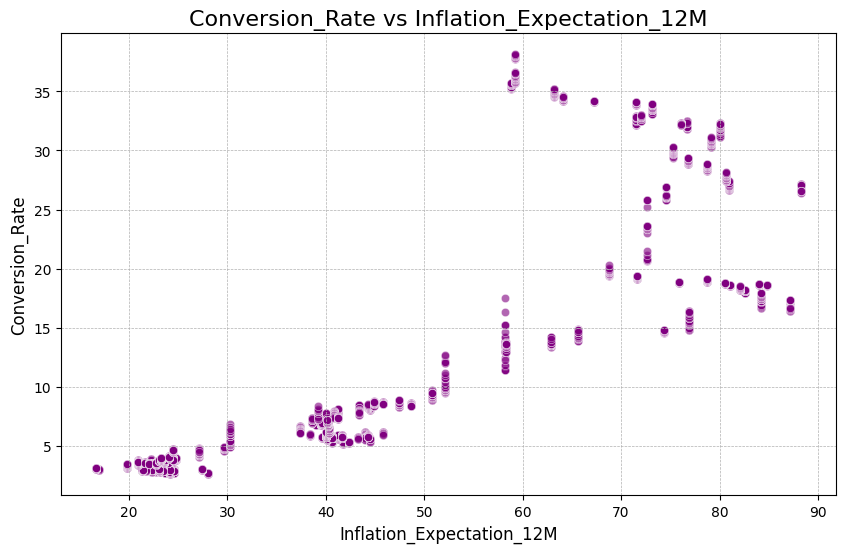

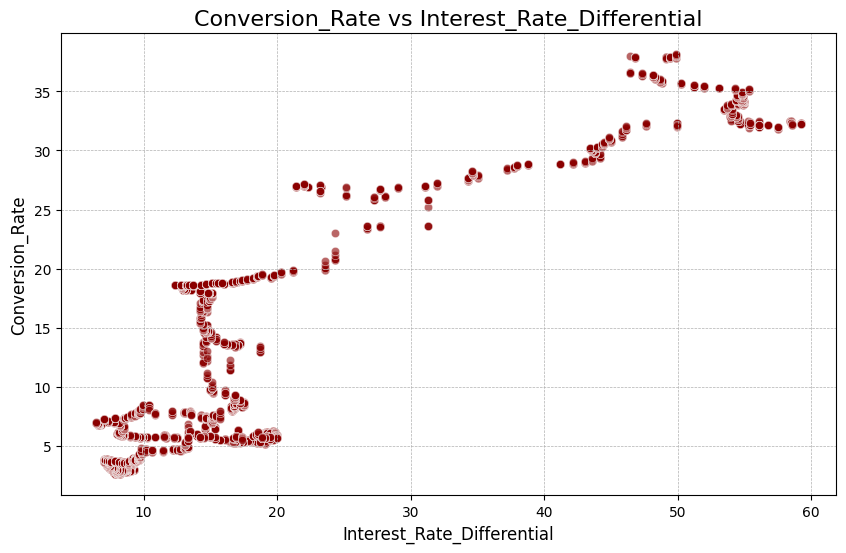

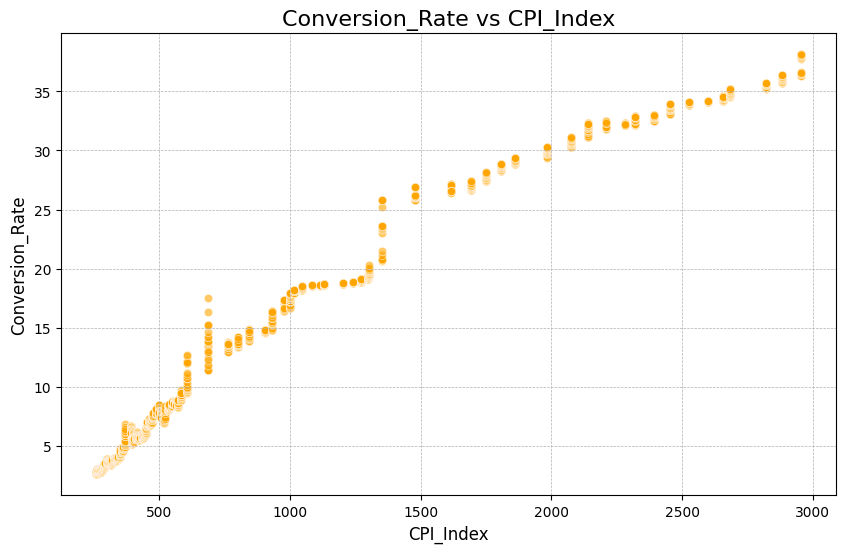

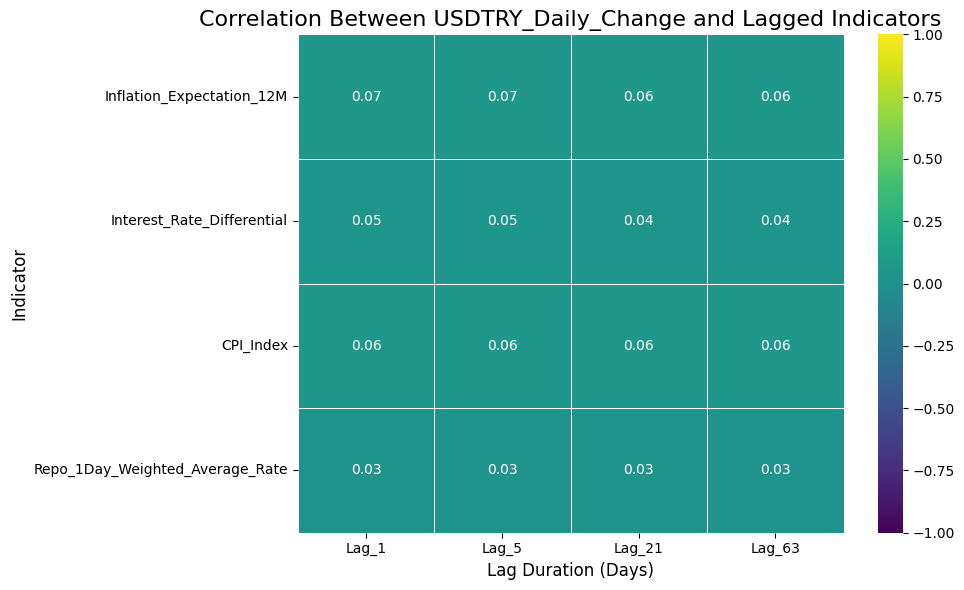


Comprehensive EDA Complete.


In [10]:

safe_scatterplot(x_var='Inflation_Expectation_12M', y_var='Conversion_Rate', data=df_merged_filled, color='purple')
safe_scatterplot(x_var='Interest_Rate_Differential', y_var='Conversion_Rate', data=df_merged_filled, color='darkred')
# Add CPI vs Conversion Rate
safe_scatterplot(x_var='CPI_Index', y_var='Conversion_Rate', data=df_merged_filled, color='orange')


# Lagged Correlation Analysis
lags = [1, 5, 21, 63] # Lag days (1 day, 1 week, 1 month, 1 quarter)
lagged_corr_vars_list = ['Inflation_Expectation_12M',
                         'Interest_Rate_Differential',
                         'CPI_Index',
                         'Repo_1Day_Weighted_Average_Rate']
target_var = 'USDTRY_Daily_Change' # Stationary target variable

lagged_correlations = {}

if target_var in df_merged_filled.columns:
    # Select explanatory variables that actually exist in the dataframe
    lagged_corr_vars = [var for var in lagged_corr_vars_list if var in df_merged_filled.columns]

    if lagged_corr_vars: # If there is at least one explanatory variable
        for var in lagged_corr_vars:
            corrs = {}
            for lag in lags:
                try:
                    combined = pd.concat([df_merged_filled[target_var], df_merged_filled[var].shift(lag)], axis=1)
                    combined.columns = [target_var, f'{var}_lag{lag}']
                    # Replace infinite values with NaN before dropping NaNs
                    combined.replace([np.inf, -np.inf], np.nan, inplace=True)
                    # Check if there's enough overlapping data for correlation
                    valid_data = combined.dropna()
                    if len(valid_data) > 10: # Calculate if there's enough overlap
                        correlation = valid_data.corr().iloc[0, 1]
                        corrs[f'Lag_{lag}'] = correlation
                    else:
                        corrs[f'Lag_{lag}'] = np.nan # Not enough data
                except Exception as e:
                    print(f"Lagged correlation calculation error ({var}, Lag {lag}): {e}")
                    corrs[f'Lag_{lag}'] = np.nan
            lagged_correlations[var] = corrs

        if lagged_correlations: # If at least one correlation was calculated
            # Drop rows that are entirely NaN (if a variable had no valid correlations)
            df_lagged_corr = pd.DataFrame(lagged_correlations).T.dropna(how='all')
            if not df_lagged_corr.empty:
                # Adjust height dynamically
                plt.figure(figsize=(10, max(6, len(df_lagged_corr)*0.8)))
                # Fix color scale from -1 to 1
                sns.heatmap(df_lagged_corr, annot=True, fmt=".2f", cmap='viridis', linewidths=.5, vmin=-1, vmax=1)
                plt.title(f'Correlation Between {target_var} and Lagged Indicators', fontsize=16)
                plt.xlabel('Lag Duration (Days)', fontsize=12)
                plt.ylabel('Indicator', fontsize=12)
                plt.tight_layout()
                plt.show() # Completed command
            else:
                 print("No (non-NaN) data found to calculate lagged correlations.")
    else:
        print("No explanatory variables found for lagged correlation.")
else:
    print(f"Target variable '{target_var}' not found for lagged correlation.")



# --- 7. Summary of Findings ---
# - The USD/TRY exchange rate exhibits a strong upward trend over the observed period (2015-2025). Stationarity tests also indicate that the rate itself is non-stationary, but its daily changes are closer to stationarity (lower ADF p-value).
# - Volatility (rolling standard deviation) of the rate has significantly increased, especially in recent years. The distribution of daily changes shows 'fat tails,' deviating from a normal distribution (QQ-Plot).
# - ACF/PACF plots suggest potential short-term autocorrelation in the rate changes (past values influencing current values).
# - The correlation heatmap (Spearman) confirms strong positive relationships between USD/TRY and the CPI Index and Inflation Expectation. The relationship with the Interest Rate Differential appears weaker and more variable.
# - Lagged correlation analysis hints that some indicators (e.g., inflation expectation, interest rate differential) might have delayed effects on USD/TRY changes, but correlation does not imply causation.
# - Forward filling was useful for merging data of different frequencies but introduces assumptions and might smooth out abrupt changes in lower-frequency data. Initial periods for some variables might still contain NaNs after filling.

print("\nComprehensive EDA Complete.")